## Homework "Распознавание рукописных цифр"

ФИО: **Дарханов Евгений Владленович**

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork
from IPython.display import clear_output
%matplotlib inline

In [23]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

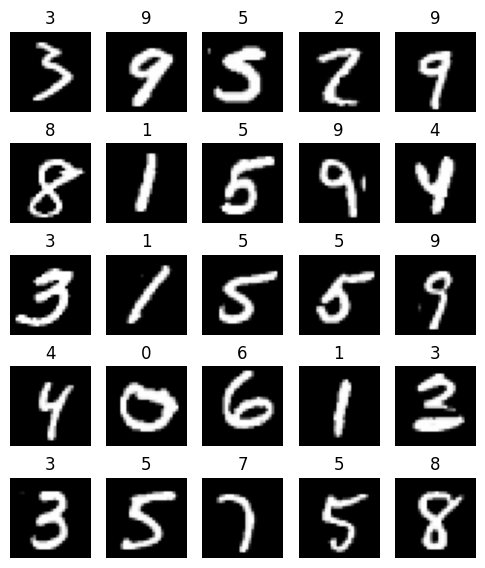

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [48]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.313/0.309	Accuracy: 0.918/0.917

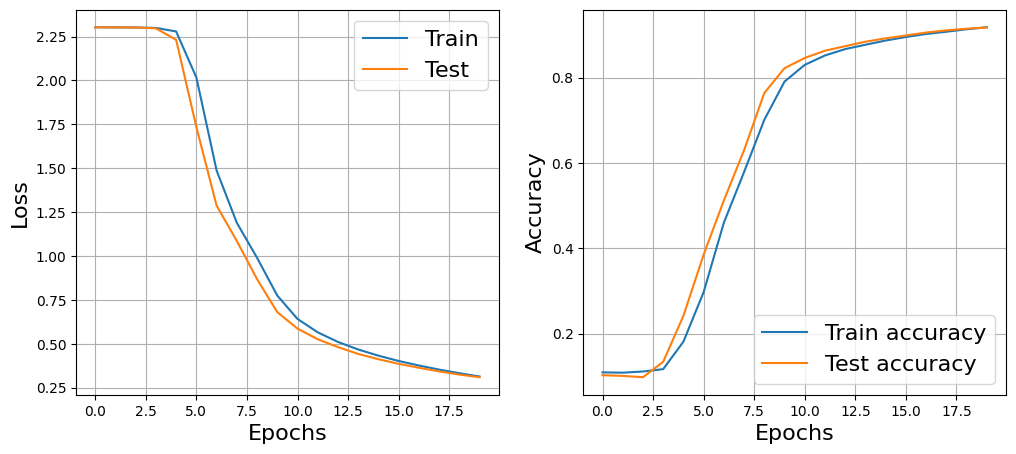

In [7]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [25]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [ ]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [9]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.034/0.089	Accuracy: 0.991/0.973

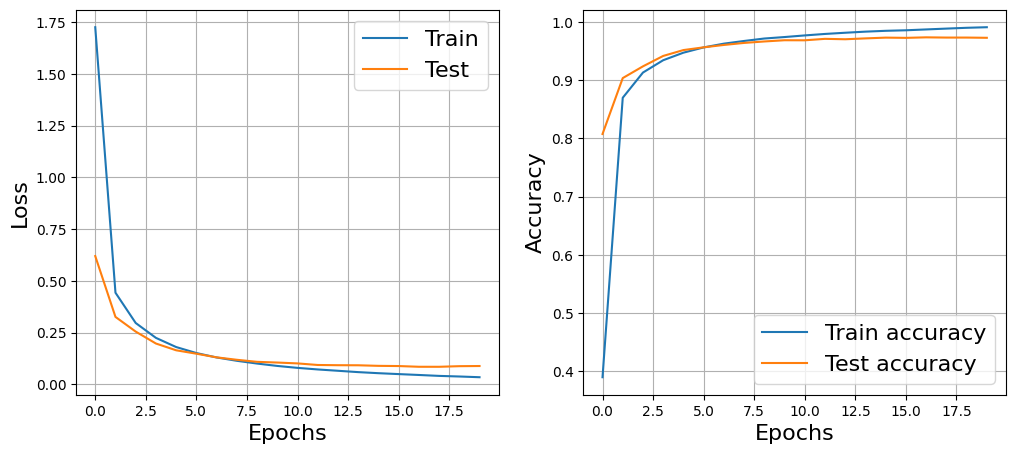

In [31]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.046/0.083	Accuracy: 0.987/0.974

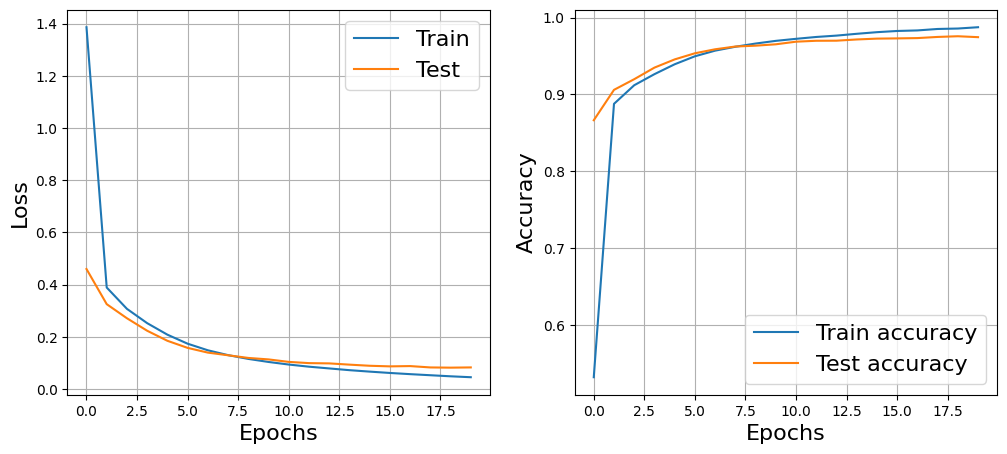

In [11]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

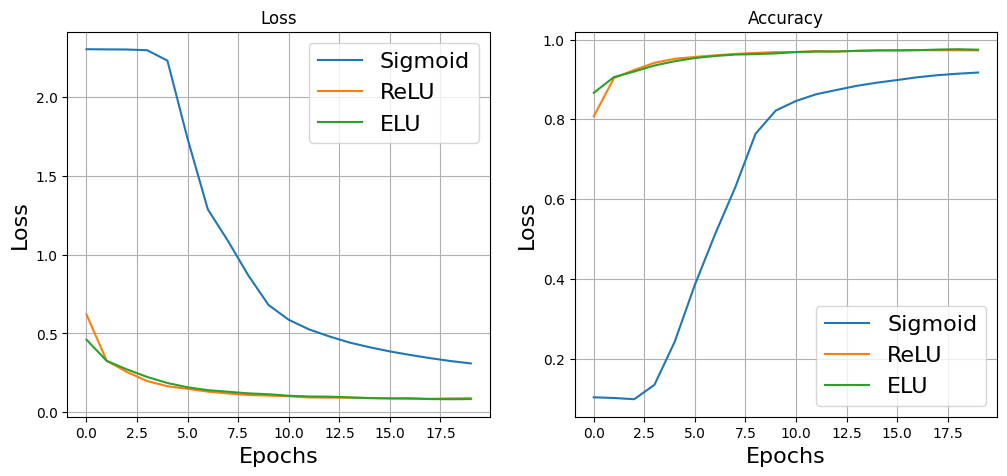

In [32]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [33]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.t = (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
        return self.t

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (1 + self.t) * (1 - self.t) * dLdy

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.029/0.071	Accuracy: 0.994/0.979

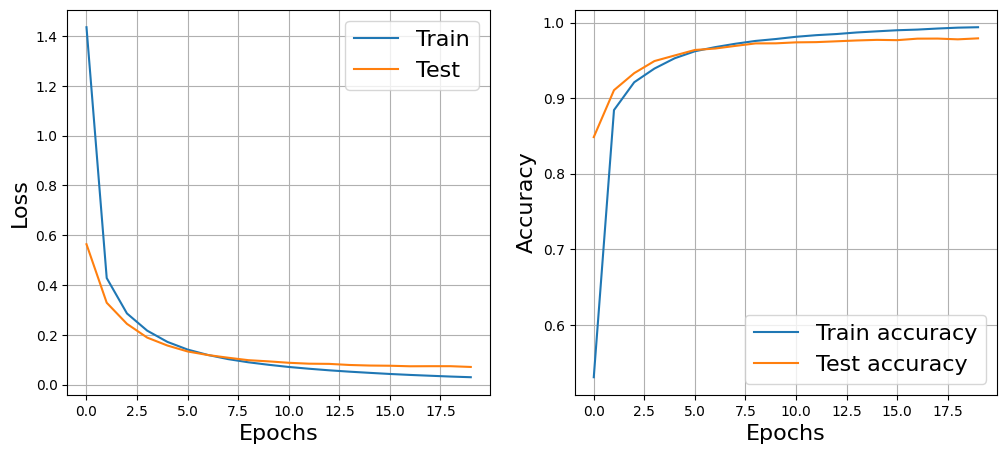

In [34]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

### Часть 3: Анализ ошибок

In [14]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

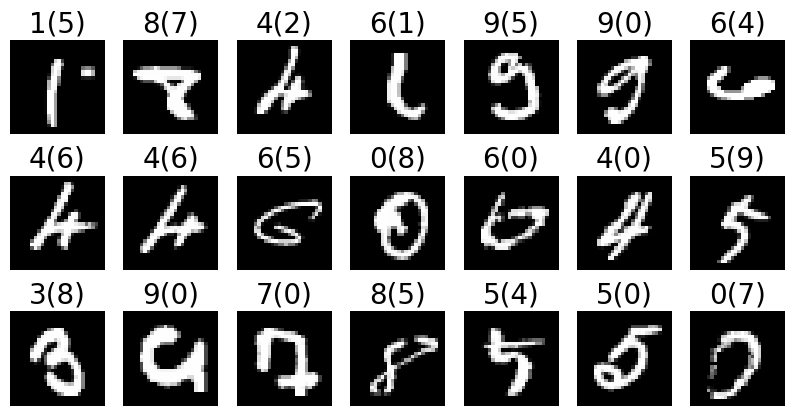

In [15]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [35]:
import torch

**Будем использовать сеть с тангенсом**

**Небольшие вращения (-15, 15)**

In [38]:
transform_rot = transforms.Compose([
    transforms.RandomRotation((-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform_rot)
test_dataset = MNIST('.', train=False, transform=transform_rot)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.067/0.078	Accuracy: 0.980/0.975

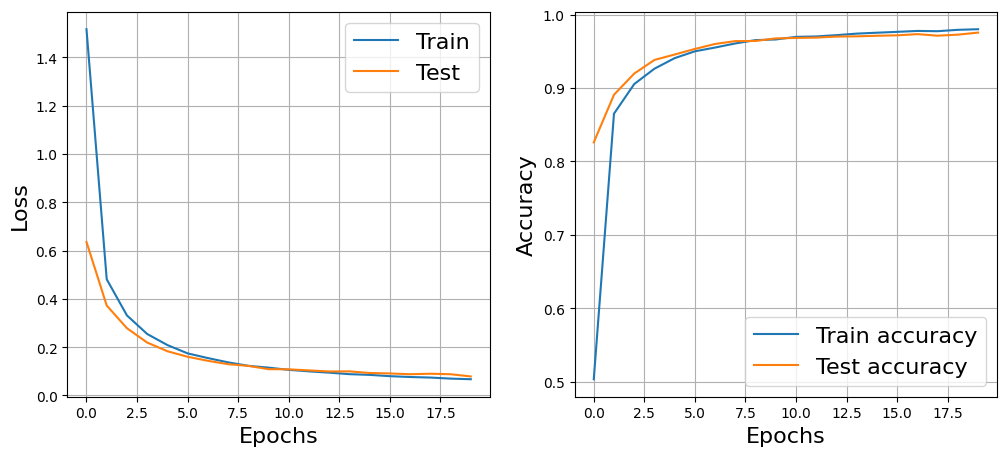

CPU times: user 16min 49s, sys: 11min 46s, total: 28min 35s
Wall time: 16min 34s


In [40]:
%%time
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_t_rot, ts_t_rot, tr_ac_t_rot, ts_ac_t_rot = train(network, 20, 0.01)

**Случайные сдвиги**

In [41]:
transform_aff = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform_aff)
test_dataset = MNIST('.', train=False, transform=transform_aff)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.216/0.202	Accuracy: 0.934/0.937

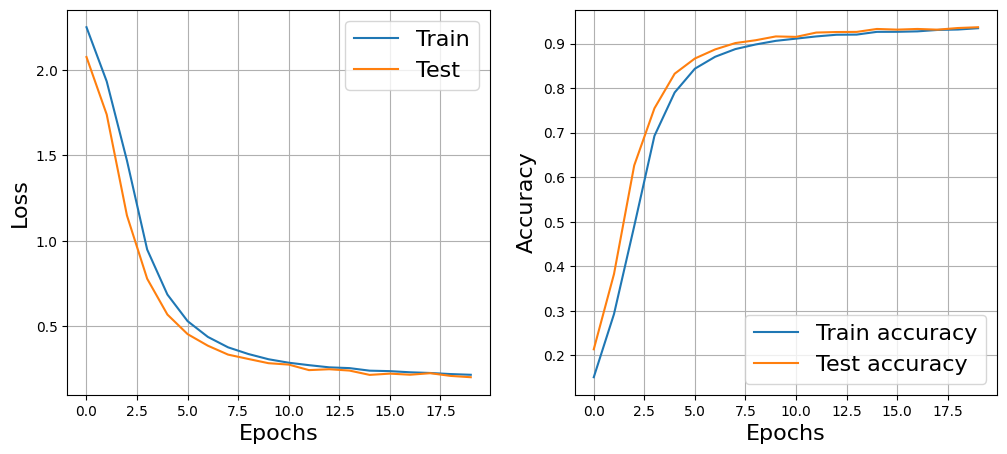

CPU times: user 19min 11s, sys: 13min 32s, total: 32min 43s
Wall time: 19min 2s


In [43]:
%%time
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_t_aff, ts_t_aff, tr_ac_t_aff, ts_ac_t_aff = train(network, 20, 0.01)

**Шум**

In [44]:
transform_noise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform_noise)
test_dataset = MNIST('.', train=False, transform=transform_noise)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.032/0.076	Accuracy: 0.993/0.977

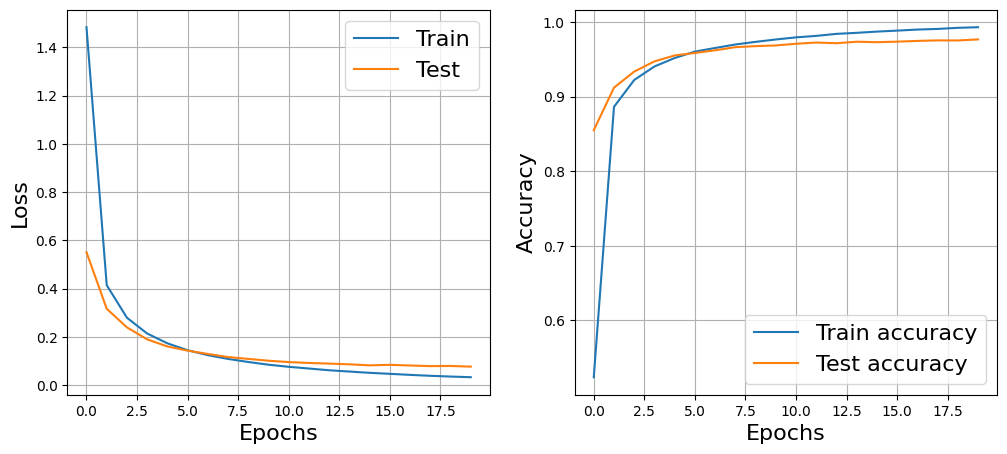

CPU times: user 14min 1s, sys: 9min 41s, total: 23min 42s
Wall time: 13min 44s


In [46]:
%%time
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_t_noise, ts_t_noise, tr_ac_t_noise, ts_ac_t_noise = train(network, 20, 0.01)

**Всё вместе**

In [47]:
transform_aug = transforms.Compose([
    transforms.RandomRotation((-15, 15)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform_aug)
test_dataset = MNIST('.', train=False, transform=transform_aug)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.275/0.255	Accuracy: 0.914/0.918

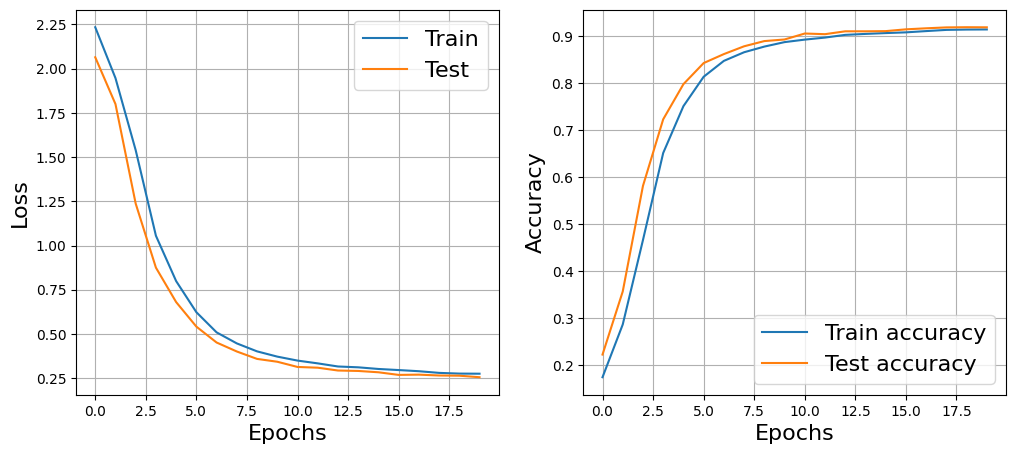

CPU times: user 25min 34s, sys: 18min 16s, total: 43min 50s
Wall time: 25min 51s


In [49]:
%%time
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_t_aug, ts_t_aug, tr_ac_t_aug, ts_ac_t_aug = train(network, 20, 0.01)

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

**Нелинейности**

- сигмоида чувствует себя менее уверенно, чем остальные функции
- Tanh, ReLU, ELU работают плюс-минус одинаково

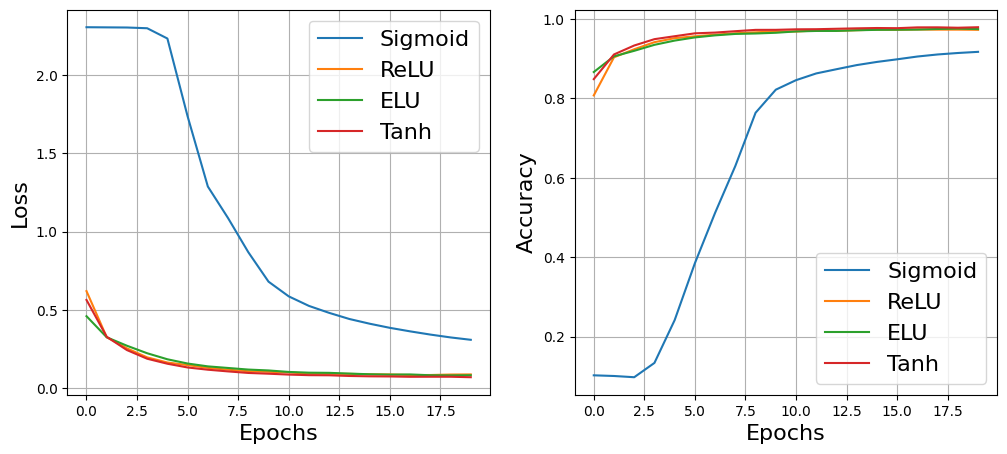

In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
# plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

**Предобработка данных**

- сеть с аугментациями обучается дольше, но результат не всегда лучше
- влияния поворотов и шума почти нет
- добавление сдвигов или всех аугментаций наоборот снижает качество

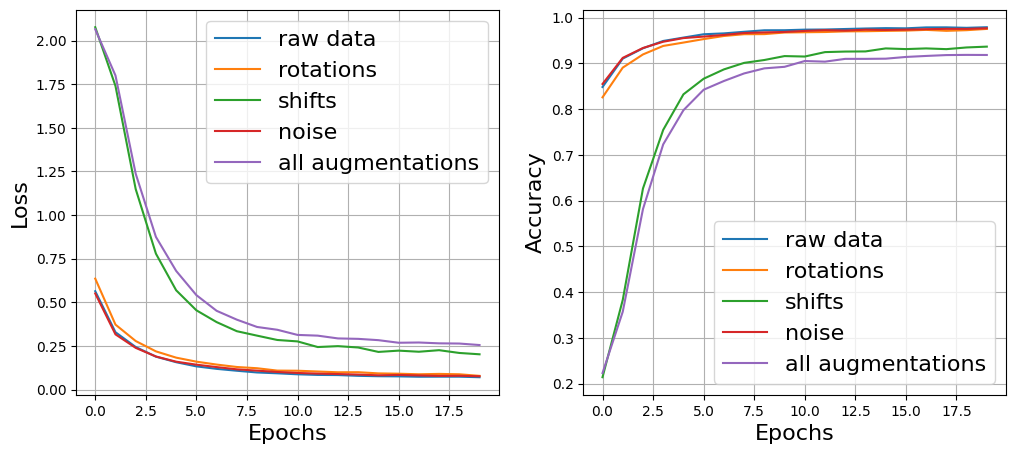

In [51]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# plt.title('Loss')
plt.plot(ts_t, label='raw data')
plt.plot(ts_t_rot, label='rotations')
plt.plot(ts_t_aff, label='shifts')
plt.plot(ts_t_noise, label='noise')
plt.plot(ts_t_aug, label='all augmentations')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
# plt.title('Accuracy')
plt.plot(ts_ac_t, label='raw data')
plt.plot(ts_ac_t_rot, label='rotations')
plt.plot(ts_ac_t_aff, label='shifts')
plt.plot(ts_ac_t_noise, label='noise')
plt.plot(ts_ac_t_aug, label='all augmentations')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()